*This notebook has been **significantly** modified from the original notebook available online, as detailed next. This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*<br>
*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

# Support Vector Machines
**Supervised learning for both classification and regression**.<br>
In this section, we will develop the intuition behind support vector machines and their use in classification problems.

We begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## SVM for discriminative classification

Here we will consider **discriminative classification**: we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

Let us start with a **simple case** of a classification task, in which **the two classes of points are well separated**:

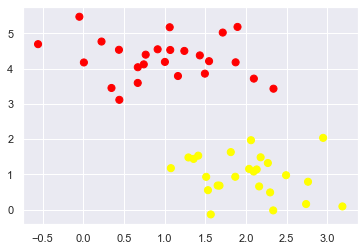

In [2]:
# sklearn.datasets.samples_generator is deprecated
#from sklearn.datasets.samples_generator import make_blobs

from sklearn.datasets import make_blobs

# generates 50 blobs, scattered around two clusters, 60% std
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

### Linear discriminative classifier
A linear discriminative classifier **would attempt to draw a straight line separating the two sets of data**, and thereby create a model for classification.
For two dimensional data like that shown here, this is a task we could do by hand.

**We immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!**

We can draw them as follows:

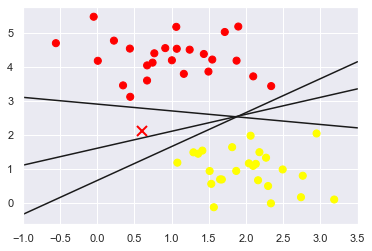

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

# adding a red X mark
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

# plotting three lines (qualitatively - not actual fit) that would make sense
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

# set the x limits of the current axes
plt.xlim(-1, 3.5);

**These are three *very* different separators** which, nevertheless, perfectly discriminate between these samples.
Depending on which one you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!

>**Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.**

## Maximizing the *Margin* between the clusters

Support vector machines offer one way to improve on this.
The intuition is this: 
>**rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.**

Here is an example of how this might look:

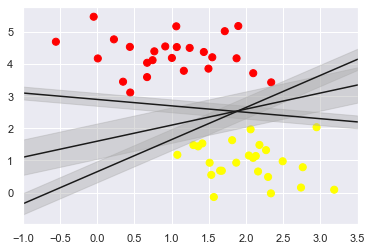

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    
    # shaded margins plotted qualitatively (as example)
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

>**The line that maximizes this margin is the one we will choose as the optimal model.**

Support vector machines are an example of such a *maximum margin* estimator.

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.

>**For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number**. <br> 
(``C`` is a tunable parameter and we'll discuss the meaning of these in more depth at the end of this notebook).

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [6]:
# this function plots the decision boundaries
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    # N.B.: vstack() stacks arrays in sequence vertically (row wise).
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

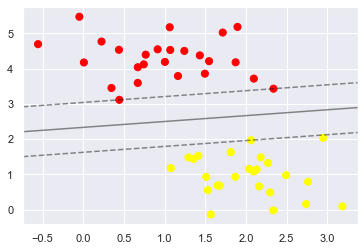

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

plot_svc_decision_function(model);

**This is the dividing line that maximizes the margin between the two sets of points.**<br>
Notice that a few of the training points just touch the margin. These points are the pivotal elements of this fit, and are known as the **support vectors**, and give the algorithm its name.
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

In [8]:
# the x,x coordiates of the three support vectors
# i.e. the three points touched by the dashed lines
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that 
>**for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!**<br>
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if **we plot the model learned from the first 60 points and first 120 points of this dataset**:

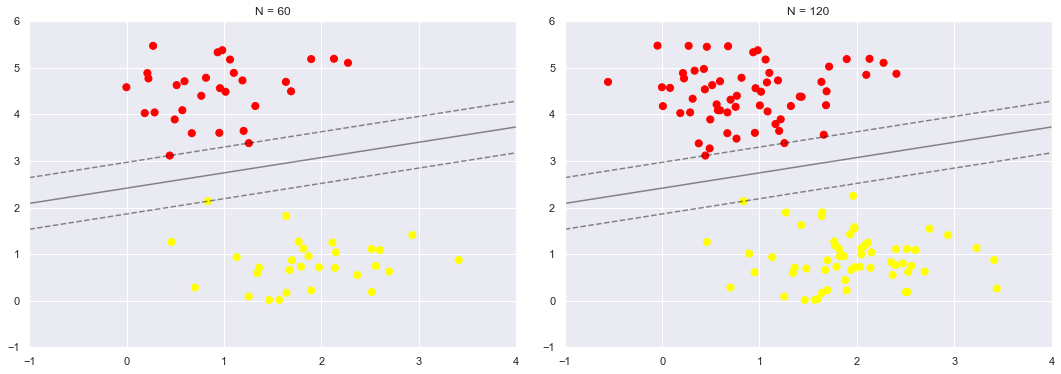

In [9]:
def plot_svm(N=10, ax=None):
    
    # making the dataset
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    
    # making a linear model and fitting it
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    
    # plot decision function margines
    plot_svc_decision_function(model, ax)

# creating a figure with the two panels
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# plotting everything on the two panels: 
# left-panel(60 training points)
# right-panel(120 training points)

for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but **the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.**
This insensitivity to the exact behavior of distant points is one of the **strengths of the SVM model.**

### However with significantly different dataset sizes, the model will change

If you are running this notebook live, you can use IPython's interactive widgets to view this feature of the SVM model interactively:

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

### Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with **kernels**.
>**To motivate the need for kernels, let's look at some data that is not linearly separable:**

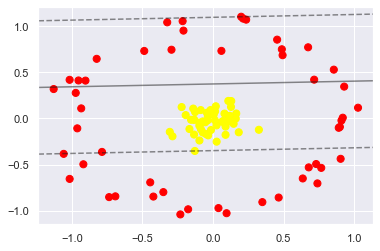

In [11]:
#from sklearn.datasets.samples_generator import make_circles
from sklearn.datasets import make_circles

# make_circles()
# makes a large circle containing a smaller circle in 2d.
# it's a simple toy dataset to visualize clustering and classification algorithms.
# Returns:
# Xndarray of shape (n_samples, 2)
# The generated samples.
# yndarray of shape (n_samples,)
# The integer labels (0 or 1) for class membership of each sample.

# creates 100 points around two circles, adding 10% noise
# X is the samples of the two circles
# y is the lables for inner and outer circles
X, y = make_circles(100, factor=.1, noise=.1)

# attempting to fit with a linear SVC
clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

# plotting the linear SVC
plot_svc_decision_function(clf, plot_support=False);

>**It is clear that no linear discrimination will *ever* be able to separate this data!**

## Projecting the data into a higher dimension

One way to address this problem is to project our data into a higher dimension, such that a linear separator *would* be sufficient.
For example, one simple projection we could use would be to compute a **radial basis function** centered on the middle clump:

In [12]:
# projects the small values (yellow ones) in the r dimension
# keeps large values (red ones) on the ground
r = np.exp(-(X ** 2).sum(1))

# N.B. numpy.sum(1) takes the elements within a ndarray, along the first
# axis (the columns), and adds them together

We can visualize this extra data dimension using a three-dimensional plot.

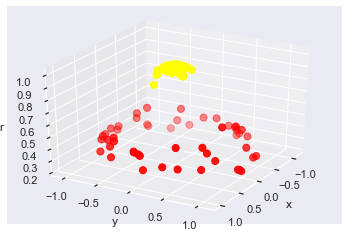

In [13]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

#interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
#         X=fixed(X), y=fixed(y));

plot_3D()

We can see that **with this additional dimension, the data becomes trivially linearly separable**, by drawing a separating plane at, say, *r*=0.7.

### We still need to find out how to automatically tune the *radial basis function*
Here we had to choose and carefully tune our projection: **if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.**

In general, the need to make such a choice is a problem: 

>**we would like to somehow automatically find the best basis functions to use.**


### Kernel tranformation
One strategy to this end is to 
>**compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.**<br>
This type of basis function transformation is known as a **kernel transformation**, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

>**In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:**

In [14]:
# setting SVC to use the radial basis function
clf = SVC(kernel='rbf', C=1E6)

# fitting the kernel to the data
clf.fit(X, y);

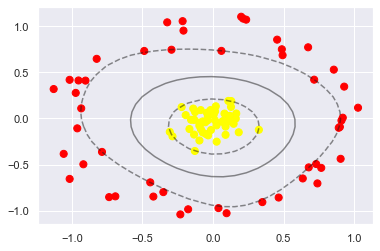

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

# this function plots the decision boundaries:
# the curve that maximises the margines
plot_svc_decision_function(clf)

# this is supposed to polot the support vectors
#plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
#            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### Useful kernel functions
kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’

### Overlapping data: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

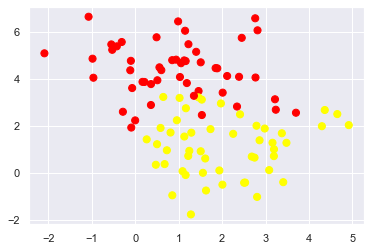

In [16]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: 

>* **SVM allows some of the points to creep into the margin if that allows a better fit.**
>* **The hardness of the margin is controlled by a tuning parameter, most often known as $C$.**

For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

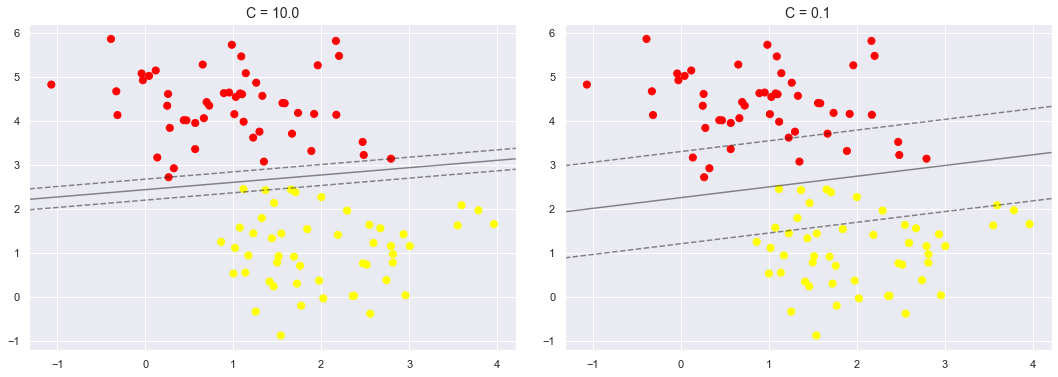

In [17]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

>**The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure.**

## Support Vector Machine Summary

We have seen here a brief intuitive introduction to the principals behind support vector machines.
These methods are a **powerful classification method** for a number of reasons:

- Their dependence on relatively few support vectors means that they are very **compact models, and take up very little memory.**
- Once the model is trained, the **prediction phase is very fast.**
- Because they are affected only by points near the margin, **they work well with high-dimensional data—even data** with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with **kernel methods makes them very versatile**, able to adapt to many types of data.

However, SVMs have several **disadvantages** as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly **dependent on a suitable choice for the softening parameter $C$**. This must be carefully chosen via **cross-validation, which can be expensive** as datasets grow in size.
- The results **do not have a direct probabilistic interpretation**. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.

With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs.
Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.

>**Still missing: how to properly evaluate classification models**<br>
>Precision, recall, F1-score, confusion matrix,...